# Exploratory Data Analysis

**Highlights**

- The top 10 origin and destination stations were found. These 10 stations out of 266 (3.6%) account for the 13% and 14% of all trips, respectively. To create a first modeling approach, we will only analyze bike supply and demand for the top station, which is **Union Station**, accounting for a 2% and 2.6% as origin and destination, respectively.
- During 2017, 63.102 bikes were taken from and to Union Station in total. Considering the 5.000 bikes available today, and Union Station's average of 172 bikes a day, with a maximum of nearly 500 bikes, *up to 10% of all bikes could be used* at this station alone. Furthermore, this mean goes up to 213 bikes during weekdays, which means trips are mainly skewed towards weekdays instead of weekends.
- A surrogate variable was created in order to approximate the demand of bikes at Union Station for every hour of every day of the year 2017. This variable is called **rate of change** and, is calculated as the amount of trips leaving the station minus the amount of trips arriving to the station. We will have a signed number that will describe the deficit or surplus of bikes for every hour, respectively.
- Union Station has a -1.2 average rate of change, meaning that on average *more bikes will arrive to the station than those leaving the station*. In terms of operations, this station will have a surplus of bikes that need to be taken from the station. 
- Peak hours present 49 bikes arriving to the station (almost twice the station's capacity) and 26 bikes leaving the station (full station capacity).
- For weekends, the average rate of change tends to zero (with low variance), which means a balanced supply and demand. This means that on average, *we will not need resources for bike replenishment at Union Station on weekends*.
- For weekdays, morning hours have a positive rate of change on average and, until 6 AM a neutral rate of change. Demand peaks at 7 AM, in which the capacity is enough to satisfy the demand of about 10 bikes. This capacity seems to be optmial and we will not need replenishment.
- For weekdays' afternoons the opposite is the case. With negative rates of change from 3 PM until 10 PM, *we will need to remove a significant amount of bikes during afternoon hours*, even more during peak hours (from 2 to 6) the capacity of the station will be exceeded many times as users will arrive and have nowhere to park their bikes. Users could even incur in overage.
- For every hour of the day, the mean and standard deviation of the rate of change will be within the capacity of the station, which is optimal for operations.
- Extreme values are present at 4 PM, the "ride back home", in which the station's capacity is exceeded. However, the "ride to work" is not symmetric to this number. This station is used for the trip back home more than the trip to work.
- Wednesday is the day that presents the *most negative peaks* for rate of change, followed in similar magnitudes by Tuesday, Thursday and Monday. On a Friday is rare to have a bike surplus.

In [1]:
# Basics
import pandas as pd
import numpy as np
import math
from datetime import datetime

# Viz
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

## Loading the data 

In [2]:
#Import the data
bike_df = pd.read_csv('../data/bts_clean.csv', parse_dates=['trip_start_time_f', 'trip_stop_time_f'])

## Narowing down the problem

In order to narrow down the analysis and test modeling approaches, we will start analyzing popular start and stop stations and how these two numbers match.

In [3]:
#Top 5 start stations (sorted by origin counts)
pd.DataFrame({'start_counts':bike_df.st_name_orig.value_counts(),
              'stop_counts': bike_df.st_name_dest.value_counts(),
             'start_pct': bike_df.st_name_orig.value_counts()/sum(bike_df.st_name_orig.value_counts())*100,
             'stop_pct': bike_df.st_name_dest.value_counts()/sum(bike_df.st_name_dest.value_counts())*100})\
.sort_values(by='start_counts', ascending=False).head(5).round(2)

,start_counts,stop_counts,start_pct,stop_pct
Union Station,27766,35604,2.02,2.60
Simcoe St / Wellington St South,20196,21613,1.47,1.58
Bathurst St / Dundas St W,18645,18376,1.36,1.34
Dundas St W / Yonge St,18206,19760,1.33,1.44
Bay St / Wellesley St W,17469,11278,1.27,0.82


In [4]:
#Top 5 stop stations (sorted by destination counts)
pd.DataFrame({'start_counts':bike_df.st_name_orig.value_counts(),
              'stop_counts': bike_df.st_name_dest.value_counts(),
             'start_pct': bike_df.st_name_orig.value_counts()/sum(bike_df.st_name_orig.value_counts())*100,
             'stop_pct': bike_df.st_name_dest.value_counts()/sum(bike_df.st_name_dest.value_counts())*100})\
.sort_values(by='stop_counts', ascending=False).head(5).round(2)

,start_counts,stop_counts,start_pct,stop_pct
Union Station,27766,35604,2.02,2.60
Simcoe St / Wellington St South,20196,21613,1.47,1.58
Dundas St W / Yonge St,18206,19760,1.33,1.44
Princess St / Adelaide St E,15905,18826,1.16,1.37
King St W / Spadina Ave,16944,18435,1.24,1.34


For the start and stop stations, the top 10 stations of 266 (3.6%) account for the 13% and 14% of all trips, respectively. To create a first modeling approach, we will only analyze supply and demand for the top station, which is **Union Station**, accounting for a 2% and 2.6% as origin and stop station, respectively.

### Extracting Union ridership

With this data, let's slice the rows containing Union Station as origin or destination.

In [5]:
bike_union = bike_df[(bike_df.st_name_orig == 'Union Station') | (bike_df.st_name_dest == 'Union Station')]
bike_union.shape

(63102, 15)

We have that during 2017, 63.102 bikes were taken from and to Union Station. Given that the systems uses about 5.000 bikes according to their website, it's critical to know how much of these bikes are being used at this station. However, that is the number of bikes today, we could think that as stations were nearly half of what they are today, the amount of bikes available could have been much less at that point in time.

Let's evaluate some statistics for this data:

In [6]:
#Summary of the amount of trips per day of the year
bike_union.groupby(bike_union.trip_start_time_f.dt.dayofyear).aggregate({'trip_id':'count'}).describe().T

,count,mean,std,min,25%,50%,75%,max
trip_id,365.0,172.882192,113.074126,2.0,81.0,141.0,267.0,499.0


With this statistics we can evidence that even considering the 5.000 bikes, Union Station uses on average 172 bikes a day, with a maximum of nearly 500 bikes! Almost 10% of all bikes available today! Let's see how these numbers are distributed for **busines days**.

In [7]:
# Count trips per weekday of the year
bike_union[~bike_union.trip_start_time_f.dt.weekday_name.isin(['Sunday', 'Saturday'])].\
groupby(bike_union.trip_start_time_f.dt.dayofyear).\
aggregate({'trip_id':'count'}).describe().T

,count,mean,std,min,25%,50%,75%,max
trip_id,260.0,213.342308,106.808538,2.0,116.75,221.0,300.5,499.0


As we see, the mean goes up to 213 bikes during weekdays, which means trips are mainly skewed towards weekdays.


## Approximating the station status variable

The 2017 ridership data should be used as raw material to create a model that helps us predict the necesary replenishment of the BST stations on an hourly basis. For this, a time series with the satus of each station could be optimal, but since that information is not at hand, we will use a **surrogate** variable: the **rate of change** of bikes inventory. 

Given the amount of bikes arriving and leaving the stations and the stations' capacity, we could create a new variable that helps us assess how the inventory is changing (increasing or decreasing) with time so as to move bikes around the city from stations with surplus to stations with deficit in an efficient manner.

### Creating dataset for stations

Now that we have narrowed down our search to analyze Union Station, it's time to create the dataset that will help us build our model. Let's first review what would be our ideal dataset:

**Ideal dataset fields**: month, day, hour, station name, station ID, number of bikes at the station

Since we don’t have the static variable that we want to predict, namely the *number of bikes at every time at each station*, we calculate a **rate of change** of this value, assuming known initial conditions. This variable will approximate the demand of bikes for Union Station for each hour of every day of the year.

**Derived dataset fields:** month, day, hour, station name, station ID, count of bikes arriving, count of bikes leaving

We will first extract the day of the year, month, day of the week and hour in which every event happened.

In [8]:
# Add new fields to dataframe
bike_union['dayofyear'] = bike_union.trip_start_time_f.dt.dayofyear
bike_union['weekday'] = bike_union.trip_start_time_f.dt.weekday
bike_union['hour'] = bike_union.trip_start_time_f.dt.hour

Now we reshape the dataframe to obtain trip counts by hour of the day of the year for trips arriving and leaving Union Station:

In [9]:
# Separating the dataframe into origin and destination registers
bike_union_orig = bike_union[bike_union.st_name_orig == 'Union Station']
bike_union_dest = bike_union[bike_union.st_name_dest == 'Union Station']

#Melting and the merging by days to get count of trips in and out of the station every hour
counts_union = pd.merge(bike_union_orig.groupby(['dayofyear','weekday','hour']).aggregate({'trip_id':'count'}).reset_index(),
                        bike_union_dest.groupby(['dayofyear','weekday','hour']).aggregate({'trip_id':'count'}).reset_index(),
                        how='outer',
                        left_on = ['dayofyear', 'weekday', 'hour'],
                        right_on = ['dayofyear', 'weekday', 'hour'],
                        suffixes=('_orig','_dest'), sort = True)

counts_union.head()

,dayofyear,weekday,hour,trip_id_orig,trip_id_dest
0,1,6,0,NaN,2.0
1,1,6,1,1.0,NaN
2,1,6,2,2.0,NaN
3,1,6,3,1.0,NaN
4,1,6,4,NaN,1.0


Here we have it, for every day of the year we have the day of the week number, the hour of the day and the amount of trips with Union Station as origin and as destination. Doing some further processing to tidy up the data.

In [10]:
#Change the column names
counts_union.columns = ['dayofyear', 'weekday', 'hour', 'count_trips_orig', 'count_trips_dest']

#Fill NAs in counts_union
counts_union.fillna(value=0, inplace=True)

#Modify so all time variables start at 0
counts_union.dayofyear = counts_union.dayofyear - 1

#Preview
counts_union.head()

,dayofyear,weekday,hour,count_trips_orig,count_trips_dest
0,0,6,0,0.0,2.0
1,0,6,1,1.0,0.0
2,0,6,2,2.0,0.0
3,0,6,3,1.0,0.0
4,0,6,4,0.0,1.0


## Exploring the rate of change

Now we create the *target variable*, which is defined as the hourly *rate of change* of bikes stock, that is to say, how many bikes are taken out vs how many bikes are brought into Union Station. This variable will be formulated as the substraction between `count_trips_orig` - `count_trips_dest`.

* When the rate of change is positive, we will have more bikes leaving the station (stock deficit).
* When the rate of change is negative, we will have more bikes are arriving to the station (stock surplus).

This variable will help us predict how many bikes should be required for every time of the day at all stations. It could also help us optimize how many bikes we need at each station to start the day optimally (initial stock), among other things.

In [11]:
#Create new variable
counts_union['rate_of_change'] = counts_union.count_trips_orig - counts_union.count_trips_dest

In [12]:
#Get statistics for all days
counts_union.rate_of_change.describe().round(1)

count    6673.0
mean       -1.2
std         6.3
min       -45.0
25%        -2.0
50%        -1.0
75%         1.0
max        26.0
Name: rate_of_change, dtype: float64

In [13]:
#Get statistics for the business days
counts_union[counts_union.weekday.isin([1,2,3,4,5])].rate_of_change.describe().round(1)

count    4812.0
mean       -1.4
std         6.7
min       -45.0
25%        -3.0
50%        -1.0
75%         1.0
max        26.0
Name: rate_of_change, dtype: float64

From this we can draw some interesting facts:

* The overall mean value of the rate of change is negative, meaning that, on average, *the inventory of bikes is increasing by 1.2 bikes every hour*, and 1.4 bikes for weekdays. We could conclude that for this station we will not require bike replenishment, on the contrary, bikes will need to be removed from the station to free up capacity for incoming riders.

* Even with outliers removed, the minimum is significantly low and would imply an arrival of bikes greater than the capacity of the station which is 26 bikes and, maybe the capacity of one replenishment truck. This variable would help us identify the hours of the day in which that is likely to happen and act accordingly.

* In terms of bike demand, we have a maximum of 26 bikes an hour, which would mean that all bikes are taken from this station, requiring restock for the following hour. This is important in terms of operations. 

Now we will check the distribution of this variable

Text(0.5, 1.0, 'Distribution of the hourly rate of change')

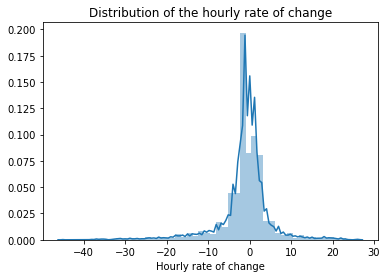

In [14]:
ax = sns.distplot(counts_union.rate_of_change)

ax.set_xlabel('Hourly rate of change')
ax.set_title('Distribution of the hourly rate of change')

The variable seems to follow a normal-like distribution with a mean close to zero, however, as discussed, the values to the left are up to twice as much as the capacity of the station. These are critical hours that must be analyzed. Now let's see the behavior of the rate of change for all days of the week.

Text(0, 0.5, 'Mean hourly rate of change')

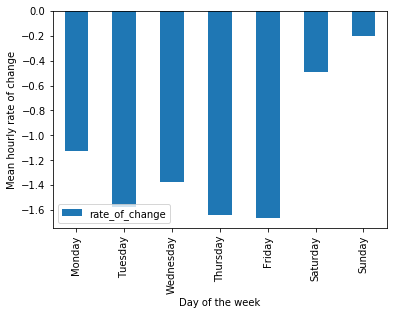

In [15]:
ax = counts_union.groupby('weekday').aggregate({'rate_of_change': 'mean'}).plot(kind='bar')

ax.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
ax.set_xlabel('Day of the week')
ax.set_ylabel('Mean hourly rate of change')

Here we can see that for this specific station everyday we have a bike surplus every day of the week, however, for weekends this surplus is almost negligible and the suply/demand is almost balanced. Now lets get more granual, by looking at hourly averages:

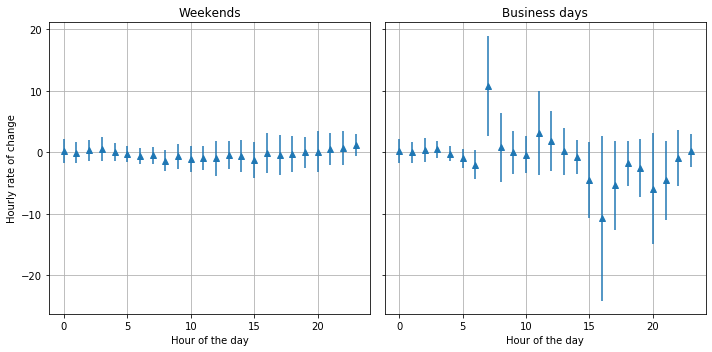

In [16]:
fig, axarr = plt.subplots(nrows = 1, ncols=2, figsize=(10,5), sharey=True)

df1 = counts_union[counts_union.weekday.isin([6,7])].groupby('hour').aggregate({'rate_of_change': ['mean', 'std']})
df2 = counts_union[~counts_union.weekday.isin([6,7])].groupby('hour').aggregate({'rate_of_change': ['mean', 'std']})

plt.sca(axarr[0])
plt.errorbar(df1.index, df1.rate_of_change['mean'], df1.rate_of_change['std'], 
             linestyle='None', marker='^')

axarr[0].set_title('Weekends')
axarr[0].set_xlabel('Hour of the day')
axarr[0].set_ylabel('Hourly rate of change')
plt.grid()

plt.sca(axarr[1])
plt.errorbar(df2.index, df2.rate_of_change['mean'], df2.rate_of_change['std'], 
             linestyle='None', marker='^')
axarr[1].set_title('Business days')
axarr[1].set_xlabel('Hour of the day')
plt.grid()
plt.tight_layout()


Here, we can evidence the following:
- For weekends, the average rate of change tends to zero (and has low variance), which means a **balanced supply and demand**. This insight is important because it will mean that on average, we will not need resources for bike replenishment at Union Station on weekends.

- For weekdays, morning hours imply a positive rate of change on average and, until 6 AM a near-zero rate of change. Demand peaks at 7 AM, in which the capacity is enough to satisfy an average demand of about 10 bikes. The capacity is optimal for this demand and we do not need to replenish bikes at Union Station.

* During afternoon we have the opposite, with **negative rates of change from 3 PM until 10 PM**. We will need to remove a significant amount of bikes during afternoon hours, even more during peak inflow hours (from 2 to 6) the capacity of the station will be exceeded users might arrive without anywhere to park their bikes, this might lead users to incur in overage affecting the service and even the probability of churn.

* One significant insight is the fact that on average, the mean and standard deviations will be within the capacity of the station, which seems to be optimal for the rate of change in general.


**Extreme values**

Let's dig deeper into ouliers. We are going to highlight the hours in which the rate of change is grater than the capacity of the station, given the fact that these peaks will create operational challenges.

In [17]:
#Extract those from the dataset
peaks = counts_union[(counts_union.rate_of_change > 26) | (counts_union.rate_of_change < -26)]

In [18]:
# Count those hours
peaks.shape[0]

65

Text(0.5, 0, 'Rate of change')

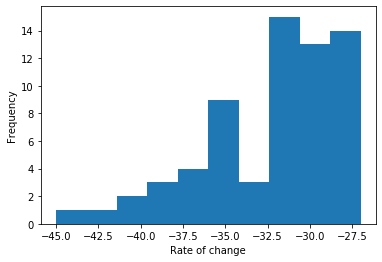

In [19]:
# How these are distributed
peaks.rate_of_change.plot(kind='hist')
plt.xlabel('Rate of change')

So we have 65 hours in which we will have negative rate of change over the station capacity. Now we will check how these are distributed throughout the day, days of the week and days of the year.

Text(0.5, 1.0, 'Count of peaks')

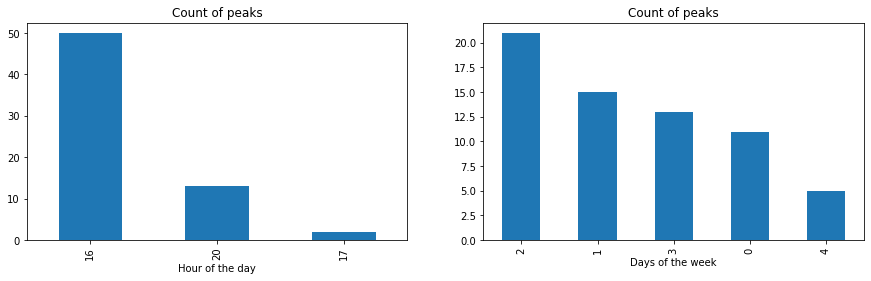

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,4))

#Check distribution during the hours of the day
peaks.hour.value_counts().plot(kind='bar', ax=ax[0])
ax[0].set_xlabel('Hour of the day')
ax[0].set_title('Count of peaks')

#Check distribution during the week
peaks.weekday.value_counts().plot(kind='bar', ax=ax[1])
ax[1].set_xlabel('Days of the week')
ax[1].set_title('Count of peaks')

In [21]:
#Check distribution during the year
peaks.dayofyear.value_counts().describe()

count    64.000000
mean      1.015625
std       0.125000
min       1.000000
25%       1.000000
50%       1.000000
75%       1.000000
max       2.000000
Name: dayofyear, dtype: float64

Some observations regarding this graphs:

* We see that these peaks are mostly at 4 PM (busy hour for commuting), which is consistent with the data previously reviewed. At this time of the day, a large number of bikes are taken to this station for the "ride back home". However, it's interesting that the "ride to work" is not symmetric to this number. This station is used for getting home from work but not as much for getting to work.
* Almost every day of the week at 4 PM we will have an overflow of bikes at this station, however, at 5 PM and 8 PM is quite rare.
* Wednesday is the day that presents the most peaks for rate of change, followed in simmilar proportion by Tuesday, Thursday and Monday. On a Friday is rare to have a bike overflow.
* Also, we have a mean of one peak a day for this station, this insight could optimize the trips taken to Union Station to pick up bikes.

In [22]:
# Export the dataset
counts_union.to_csv('union_df.csv', index=False)